## Stochastic linear program (SLP) to take into account uncertainty

In this sample we illustrate the usage of SLP for energy portfolios. Our demonstration implements a two-stage problem for a simple portfolio. It may be extended to any portfolio.

## Some prerequisites
### Basics

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from copy import deepcopy
# in case eao is not installed
from os.path import dirname, join
import sys
# in case eao is not installed, set path
myDir = os.path.join(os.getcwd(), '../..')
sys.path.append(myDir)
addDir = os.path.join(os.getcwd(), '../../../..')
sys.path.append(addDir)

import eaopack as eao

import matplotlib.pyplot as plt
%matplotlib inline



### Parameter setting
Defining timegrid and main portfolio settings as well as settings for SLP. Note that we do not explain the setup in detail. Please refer to the basic samples to understand the concepts and parameters

For the SLP part we define the number of samples to be used. Using the parameter 'sigma' we can adjust uncertainty in price samples. The parameter 'start_future' defines the transition between the two stages of the SLP - present and future. In the two-stage setup we determine the optimal steps in the present given an uncertain future

In [2]:
Start = dt.date(2021,1,1)
End   = dt.date(2021,1,5)
start_future = Start+dt.timedelta(days=2)
n_samples    = 5
sigma        = .5

file_chart = join(myDir, 'chart_slp.pdf')

## Set up portfolio
(1) defining the assets of the portfolio (here a battery and a market with uncertain prices)
(2) definition of how prices are sampled

In [3]:
node = eao.assets.Node('home')
timegrid = eao.assets.Timegrid(Start, End, freq = 'h')
battery  = eao.assets.Storage(name='battery', nodes=node, cap_in= 1, cap_out=1, start_level= 24, end_level=24, size= 72)
market   = eao.assets.SimpleContract(name = 'market', nodes = node, min_cap= -10, max_cap= 10, price = 'spot')

def get_price(start, end, name = 'spot', n_samples = 1, sigma = 0.2, start_future = None):
    dates = pd.date_range(start, end, freq ='h')
    prices = []
    np.random.seed(123)
    n = len(dates)
    if not start_future is None:
        Ip = (dates <= pd.Timestamp(start_future))
    else:
        Ip = (dates <= dates.max())
    for iS in range(0,n_samples):
        means = 2+np.sin(4+np.linspace(0.,4., n)) 
        process = np.zeros(n)
        for i,pres in enumerate(Ip):
            if not pres:
                process[i] = process[i-1] + np.random.randn(1)*sigma    
        prices.append({'start' : dates.values, 'values': means + process})
    return prices

In [4]:
# define mean price
mean_price      = get_price(Start, End, sigma = 0)[0]
# standard format needs to be cast onto timegrid
mean_price_grid = {'spot' :timegrid.values_to_grid(mean_price)}

# create price samples for future (past included, but irrelevant)
# Note: May want to implement possibility to give only future prices
sample_prices = get_price(Start, End, n_samples=n_samples, sigma = sigma, start_future = start_future)
sample_prices_grid = []
for mys in sample_prices:
    sample_prices_grid.append( {'spot' :timegrid.values_to_grid(mys)} )


portf  = eao.portfolio.Portfolio([battery, market])

## Perform the optimization
For comparison we perform a deterministic optimization on the 'mean price' and an SLP on given samples for the future

In [5]:
op     = portf.setup_optim_problem(mean_price_grid, timegrid)
res_hard = op.optimize()
op_slp = eao.stoch_lin_prog.make_slp(portf = portf, 
                                    optim_problem= deepcopy(op),
                                    timegrid=timegrid,
                                    start_future = start_future, 
                                    samples = sample_prices_grid)
res_slp = op_slp.optimize()

## Create charts and interpret the results

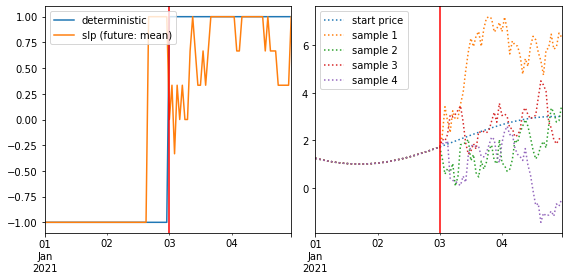

In [6]:
### check and illustrate results
out_hard = eao.io.extract_output(portf, op,     res_hard)
out_slp  = eao.io.extract_output(portf, op_slp, res_slp)

collect = pd.DataFrame()
collect['deterministic'] = out_hard['dispatch']['battery']
collect['slp (future: mean)']  = out_slp['dispatch']['battery']
collect['start price'] = mean_price_grid['spot']
timegrid.set_restricted_grid(end = start_future)
for i, ts in enumerate(sample_prices_grid):
    ts['spot'][timegrid.restricted.I] = mean_price_grid['spot'][timegrid.restricted.I]
    collect['sample '+'{:1.0f}'.format(i)] = ts['spot']    

fig, ax = plt.subplots(1,2, tight_layout = True, figsize=(8,4))
collect[['deterministic','slp (future: mean)']].plot(ax = ax[0])
collect[['start price', 'sample 1', 'sample 2', 'sample 3', 'sample 4']].plot(ax = ax[1], style = ':')
ax[0].axvline(x = start_future, c = 'r')
ax[1].axvline(x = start_future, c = 'r')
ax[0].legend(loc = 'upper left')
ax[1].legend(loc = 'upper left')
plt.show()


### Interpretation

The red line indicates the start of the uncertain future (Jan 3). While for the pending decision (stage 1) prices are certain, for the future (stage 2) we have five price samples that encode the uncertainty. Solutions in this example are relatively similar -- but note that the deterministic optimization charges the storage maximally undil Jan 03 as future prices are higher than present prices. Since uncertainty is high, the SLP solution starts discharching earlier, as future prices may be higher today but are uncertain. 

## Notes: 

In our implementation we provide a formulation of a two-stage SLP generically for any  portfolio structure. For the two-stage case problems can typically be handled and often already provide a good appoximation. For the multi-stage case we believe that it will be necessary to resort to numerical approximations, strategies that are specific to the given portfolio or others such as methods from machine learning. Providing a solution to the SLP for a relevant problem class could be a valuable research thread for further work.